In [1]:
# %%
from gpytorch.kernels.periodic_kernel import PeriodicKernel
from gpytorch.likelihoods import (
    GaussianLikelihood, 
    FixedNoiseGaussianLikelihood,
)
from gpytorch.means import (
    ZeroMean, 
    ConstantMean, 
    LinearMean,
)
# http://www.gaussianprocess.org/gpml/chapters/RW4.pdf
# https://www.cs.toronto.edu/~duvenaud/cookbook/
from gpytorch.kernels import (
    RBFKernel,
    RQKernel,  
    MaternKernel,
    SpectralMixtureKernel,
    AdditiveKernel,
    PolynomialKernel,
    ScaleKernel,
    ProductKernel,
    LinearKernel
)

import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from torch.nn.modules.loss import SoftMarginLoss

from data import (
    get_silso_data, 
    centre_x, 
    split_train_test, 
    to_tensor, 
    sample_random, sample_interval, sample_meaninterval, 
    plot_data,
)
from models import GP, train, data_loglik, calc_BIC
from utility import (
    spectral_density, 
    get_peaks, 
    plot_losses, 
    plot_density, 
    plot_kernel, 
    plot_transform, 
)
from transforms import (
    identity, 
    log_transform, exp_transform, 
    invsoftplus_transform, softplus_transform, 
    power_transform, 
    TanhWarp, LogWarp, 
)

In [2]:
# %% data
data = get_silso_data('SN_m_tot_V2.0')
data = centre_x(data)

sampling_interval = 4  # months
f_s = 12 / sampling_interval
sampledata_int = sample_interval(data, sampling_interval)
sampledata_mean = sample_meaninterval(data, sampling_interval, ['year_frac', 'ssn_total'])
# sampledata_mean['year_frac'] += sampling_interval / 12 / 2
sampledata = sampledata_mean

min_train_year = 1848  # 1900
min_test_year = 2010  # 1979  # 2018
traindata, testdata = split_train_test(sampledata, min_test_year=min_test_year, min_train_year=min_train_year, year_col='year_frac')

train_x, train_y = to_tensor(traindata['year_frac']), to_tensor(traindata['ssn_total'])
test_x, test_y = to_tensor(testdata['year_frac']), to_tensor(testdata['ssn_total'])

history_x = torch.cat([train_x, test_x])
future_x = torch.tensor([2022 + sampling_interval * 1/12*(i+1) for i in range(11*12//sampling_interval)])
all_x = torch.cat([history_x, future_x])

../data/SILSO data/SN_m_tot_V2.0.csv


In [3]:
# %% transforms
p = 1/2
pt = power_transform(p)
ipt = power_transform(1/p)
input_transform = pt
output_transform = ipt

transf_train_y = input_transform(train_y)
transf_train_y = input_transform(train_y)
transf_test_y = input_transform(test_y)

assert torch.allclose(train_y, output_transform(transf_train_y))
# plot_transform(train_y, input_transform)

# kernels

In [17]:
# %% define kernels
base_kernels = []
base_kernel_names = []

def create_smk(num_mixtures):
    def _create_smk(x, y):
        smk = SpectralMixtureKernel(num_mixtures)
        smk.initialize_from_data_empspect(x, y)
        return smk
    return _create_smk

smk_mixtures = [1, 2, 3, 4, 6, 8, 10]
for num_mixtures in smk_mixtures:
    base_kernels.append(create_smk(num_mixtures))
    base_kernel_names.append(f'smk_{num_mixtures}')

base_kernels.append(lambda x,y: ScaleKernel(PeriodicKernel().initialize(period_length=11)))
base_kernel_names.append('periodic')
base_kernels.append(lambda x,y: ScaleKernel(RBFKernel()))
base_kernel_names.append('rbf')
base_kernels.append(lambda x,y: ScaleKernel(RQKernel()))
base_kernel_names.append('rq')
# this creates a lot of PSD errors...
# base_kernels.append(lambda x,y: ScaleKernel(LinearKernel()))
# base_kernel_names.append('linear')

def create_matern(nu):
    def _create_matern(x, y):
        return ScaleKernel(MaternKernel(nu))
    return _create_matern 

for nu in [0.5, 1.5, 2.5]:
    base_kernels.append(create_matern(nu))
    base_kernel_names.append(f'matern_{nu}')

base_compositions = [AdditiveKernel, ProductKernel]
base_composition_names = ['+', '*']

# functions

In [110]:
def fit_model(x, y, kernel, training_iter = 2000, seed=0):
    mean = ConstantMean(prior=gpytorch.priors.NormalPrior(y.mean(), y.std()))
    noise_prior = gpytorch.priors.GammaPrior(1.05, 0.05)
    noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
    lik = GaussianLikelihood(
        noise_prior=noise_prior,
        noise_constraint=gpytorch.constraints.constraints.GreaterThan(
            1e-6,
            transform=None,
            initial_value=noise_prior_mode,
        ),
    )

    model = GP(mean, kernel(x, y), x, y, likelihood=lik, warp=None)
    torch.manual_seed(seed)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    train(model, optimizer, mll, train_x, transf_train_y, training_iter)
    torch.save(model.state_dict(), f'./models/search/gp_{hash(model)}.model')
    return model

def fit_model_repeat(x, y, kernel, repeats, training_iter=2000, criteria=calc_BIC, seed=0):
    torch.manual_seed(seed)
    best_criteria = None
    best_model = None
    for _ in range(repeats):
        model = fit_model(x, y, kernel, seed=torch.random.seed(), training_iter=training_iter)
        c = criteria(model, x, y, train=True)
        if not best_criteria or c < best_criteria:
            best_criteria = c 
            best_model = model 
    return best_model, best_criteria

def create_composite_kernel(c, k1, k2):
    def _create_composite_kernel(x, y):
        return c(k1(x, y), k2(x, y))
    return _create_composite_kernel

def kernel_search(x, y, base_kernels, base_kernel_names, base_compositions, base_composition_names, max_depth, 
                  test_x=None, test_y=None, 
                  training_iter=2000, fit_repeats=1, criteria=calc_BIC, seed=0, 
                  depth_0_kernels=None, depth_0_kernel_names=None, early_abort=True, 
                 ):
    kernel_cache = dict()
    criteria_cache = dict()
    best_criteria = np.inf
    best_kernel = None
    best_kernel_name = ''
    print('[INFO] beginning base kernel search')
    if depth_0_kernels is None or depth_0_kernel_names is None: 
        depth_0_kernels = base_kernels
        depth_0_kernel_names = base_kernel_names
    for k, kernel in zip(depth_0_kernel_names, depth_0_kernels): 
        model, crit = fit_model_repeat(x, y, kernel, fit_repeats, training_iter=training_iter, criteria=criteria, seed=seed)
        if test_x is not None and test_y is not None:
            crit = criteria(model, test_x, test_y, train=False)
        kernel_cache.setdefault(0, dict())[k] = kernel
        criteria_cache.setdefault(0, dict())[k] = crit
        if crit < best_criteria: 
            best_criteria = crit
            best_kernel = kernel
            best_kernel_name = k
    print(f'''[INFO] finished base kernel search
        best criteria: {best_criteria}
        best kernel: {best_kernel_name}
    ''')

    for depth in range(max_depth):
        print(f'[INFO] beginning composite kernel search, depth={depth}')
        best_kernel_name, best_criteria = min(criteria_cache[depth].items(), key=lambda kv: kv[1])
        best_kernel = kernel_cache[depth][best_kernel_name]
        new_best_criteria = np.inf
        new_best_kernel = None
        new_best_kernel_name = ''
        for c, comp in zip(base_composition_names, base_compositions):
            for k, new_kernel in zip(base_kernel_names, base_kernels):
                kernel = create_composite_kernel(comp, best_kernel, new_kernel)
                model, crit = fit_model_repeat(x, y, kernel, fit_repeats, training_iter=training_iter, criteria=criteria, seed=seed)
                if test_x is not None and test_y is not None:
                    crit = criteria(model, test_x, test_y, train=False)
                kc = '('+best_kernel_name+c+k+')'
                kernel_cache.setdefault(depth+1, dict())[kc] = kernel
                criteria_cache.setdefault(depth+1, dict())[kc] = crit
                if crit < new_best_criteria:
                    new_best_criteria = crit
                    new_best_kernel = kernel
                    new_best_kernel_name = kc
        print(f'''[INFO] finished composite kernel search, depth={depth}
            best criteria: {new_best_criteria}
            best kernel: {new_best_kernel_name}
        ''')
        if early_abort and new_best_criteria > best_criteria: 
            print(f'[INFO] could not find a better composite kernel at depth {depth}; aborting')
            break
    
    return kernel_cache, criteria_cache

def nll(model, x, y, train=False):
    return -data_loglik(model, x, y, train=train).item()

## testing

In [13]:
model = fit_model(train_x, transf_train_y, base_kernels[1], training_iter=10)

Epoch: 100%|██████████| 10/10 [00:00<00:00, 76.29it/s, loss=8.74]


In [14]:
model, bic = fit_model_repeat(train_x, transf_train_y, base_kernels[1], 2, training_iter=10)
bic

Epoch: 100%|██████████| 10/10 [00:00<00:00, 38.45it/s, loss=9.66]


5587.483809616204

## only need one smk kernel

### bic

In [18]:
%%time
kernel_cache, bic_cache = kernel_search(train_x, transf_train_y, 
                                        base_kernels[:len(smk_mixtures)], base_kernel_names[:len(smk_mixtures)],
                                        base_compositions, base_composition_names, 
                                        -1, criteria=calc_BIC, test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000)

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:29<00:00, 34.14it/s, loss=1.6]


[INFO] finished base kernel search
        best BIC: 133.50532496956293
        best kernel: smk_2
    
CPU times: user 2h 48min 45s, sys: 8min 13s, total: 2h 56min 59s
Wall time: 12min 14s


In [19]:
bic_cache

{0: {'smk_1': 160.01168038563992,
  'smk_2': 133.50532496956293,
  'smk_3': 140.93038129665,
  'smk_4': 150.09131561445975,
  'smk_6': 170.5946036226378,
  'smk_8': 196.34717446772996,
  'smk_10': 216.20104841340802}}

### nll

In [20]:
%%time
kernel_cache, nll_cache = kernel_search(train_x, transf_train_y, 
                                        base_kernels[:len(smk_mixtures)], base_kernel_names[:len(smk_mixtures)],
                                        base_compositions, base_composition_names, 
                                        -1, criteria=nll, test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000)

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:27<00:00, 35.72it/s, loss=1.55]


[INFO] finished base kernel search
        best BIC: 49.24320983886719
        best kernel: smk_8
    
CPU times: user 2h 48min 23s, sys: 3min 37s, total: 2h 52min
Wall time: 11min 41s


In [36]:
nll_cache

{0: {'smk_1': 70.33042907714844,
  'smk_2': 52.70832824707031,
  'smk_3': 50.77211380004883,
  'smk_4': 50.75431823730469,
  'smk_6': 49.882301330566406,
  'smk_8': 49.24320983886719,
  'smk_10': 49.968841552734375}}

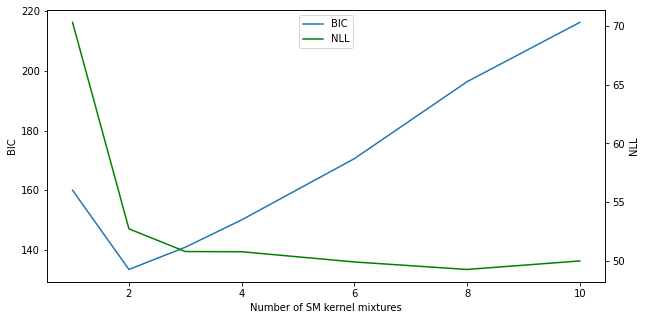

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
l1 = ax.plot(smk_mixtures, list(bic_cache[0].values()), label='BIC')
ax2 = ax.twinx()
l2 = ax2.plot(smk_mixtures, list(nll_cache[0].values()), label='NLL', c='g')
ax.set_ylabel('BIC')
ax2.set_ylabel('NLL')
ax.set_xlabel('Number of SM kernel mixtures')

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=9)
fig.savefig('./smk-bic-vs-nll.png')

# kernel search

In [22]:
x, y = train_x, transf_train_y

## se, per, rq, m25; BIC

In [70]:
kernels = base_kernels[len(smk_mixtures):len(smk_mixtures)+3] + [base_kernels[-1]]
kernel_names = base_kernel_names[len(smk_mixtures):len(smk_mixtures)+3] + [base_kernel_names[-1]]
kernel_names

['periodic', 'rbf', 'rq', 'matern_2.5']

In [75]:
%%time
kernel_cache, bic_cache = kernel_search(train_x, transf_train_y, kernels, kernel_names,
                                        base_compositions, base_composition_names, 
                                        2, test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000)

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:47<00:00, 21.14it/s, loss=1.7]


[INFO] finished base kernel search
        best BIC: 119.71098310245725
        best kernel: rbf
    
[INFO] beginning composite kernel search, depth=0


Epoch: 100%|██████████| 1000/1000 [00:40<00:00, 24.46it/s, loss=1.66]


[INFO] finished composite kernel search, depth=0
            best BIC: 125.28469822546322
            best kernel: (rbf+matern_2.5)
        
[INFO] could not find a better composite kernel at depth 0; aborting
CPU times: user 6h 33min 3s, sys: 4min 40s, total: 6h 37min 44s
Wall time: 29min 42s


In [77]:
bic_cache

{0: {'periodic': 222.22507455067898,
  'rbf': 119.71098310245725,
  'rq': 123.48397042470242,
  'matern_2.5': 119.80085737003537},
 1: {'(rbf+periodic)': 130.2598645027865,
  '(rbf+rbf)': 125.63204929968197,
  '(rbf+rq)': 128.9951855477084,
  '(rbf+matern_2.5)': 125.28469822546322,
  '(rbf*periodic)': 137.9683071907748,
  '(rbf*rbf)': 125.62561009069759,
  '(rbf*rq)': 129.25489776694667,
  '(rbf*matern_2.5)': 125.48760960241634}}

In [ ]:
# %% analysis
# depth = max(bic_cache.keys())
# kname, score = min(bic_cache[depth].items(), key=lambda kv: kv[1])
best_crit = min(i for v in bic_cache.values() for i in list(v.values()))
for d in range(len(bic_cache)):
    for k,v in bic_cache[d].items():
        if v == best_crit: 
            kname = k
            break
            
k = kernel_cache[depth][kname]

model, bic = fit_model_repeat(x, y, k, 5, training_iter=2000)

BIC 1627.30
train log-likelihood: -1.18
BIC 119.37
test log-likelihood: -1.46


/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


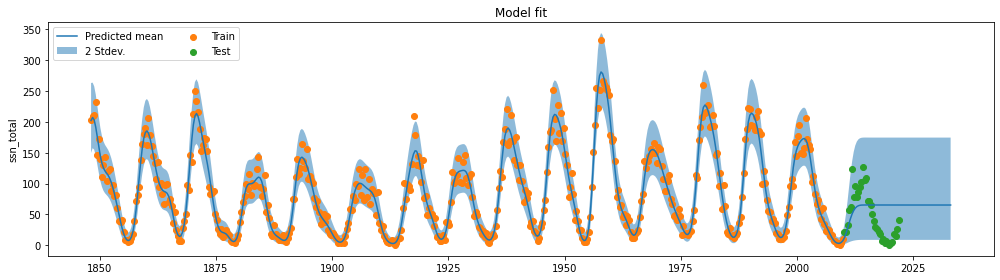

In [95]:
def plot_model_fit(model, figsize=(14, 4), transform=identity):
    pred, lower, upper = model.predict(all_x)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 1
    else:
        ts = [(identity, 'transformed ssn_total'), (transform, 'ssn_total')]
        nplots = 2
    fig, ax = plt.subplots(figsize=figsize)
    t, ylbl = ts[1]
    ax_t = ax
    ax_t.set_title('Model fit')
    ax_t.set_ylabel(ylbl)
    ax_t.plot(all_x, t(pred.mean).numpy().flatten(), label='Predicted mean')
    ax_t.fill_between(all_x, t(lower).numpy(), t(upper).numpy(), alpha=0.5, label='2 Stdev.')
    data_ = data.loc[data.year_frac > min_train_year]
    ax_t.scatter(train_x, t(transf_train_y), label='Train')
    ax_t.scatter(test_x, t(transf_test_y), label='Test')
    ax_t.legend(loc='upper left', ncol=2)

    fig.tight_layout()
    return fig, ax

print(f'BIC {calc_BIC(model, train_x, transf_train_y, train=True):.2f}')
print(f'train log-likelihood: {data_loglik(model, train_x, transf_train_y)/train_x.shape[0]:.2f}')
print(f'BIC {calc_BIC(model, test_x, transf_test_y):.2f}')
print(f'test log-likelihood: {data_loglik(model, test_x, transf_test_y)/test_x.shape[0]:.2f}')
fig, ax = plot_model_fit(model, transform=output_transform)
fig.savefig('./kernel-search-se-per-rq-m25-BIC.png')

## se, per, rq, m25; loglikelihood

In [111]:
%%time
kernel_cache, nll_cache = kernel_search(train_x, transf_train_y, kernels, kernel_names,
                                        base_compositions, base_composition_names, 
                                        3, criteria=nll, test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000)

[INFO] beginning base kernel search


Epoch:  49%|████▉     | 488/1000 [00:10<00:08, 57.86it/s, loss=1.87]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch:   8%|▊         | 79/1000 [00:02<00:34, 26.44it/s, loss=2.61]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch:  37%|███▋      | 372/1000 [00:11<00:20, 30.31it/s, loss=1.81]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this l

Epoch: 100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s, loss=1.65]


[INFO] finished composite kernel search, depth=1
            best criteria: 46.060306549072266
            best kernel: ((smk_8*smk_8)*smk_8)
        
[INFO] beginning composite kernel search, depth=2


Epoch: 100%|██████████| 1000/1000 [01:32<00:00, 10.78it/s, loss=1.65]


[INFO] finished composite kernel search, depth=2
            best criteria: 46.37102127075195
            best kernel: (((smk_8*smk_8)*smk_8)+rbf)
        
[INFO] could not find a better composite kernel at depth 2; aborting
CPU times: user 1d 13h 42min 13s, sys: 45min 39s, total: 1d 14h 27min 53s
Wall time: 2h 50min 56s


In [118]:
nll_cache

{0: {'smk_8': 49.36505126953125,
  'periodic': 102.15373992919922,
  'rbf': 52.688453674316406,
  'rq': 52.78318786621094,
  'matern_0.5': 56.0675163269043,
  'matern_1.5': 53.18393325805664,
  'matern_2.5': 52.73339080810547},
 1: {'(smk_8+smk_8)': 48.485931396484375,
  '(smk_8+periodic)': 48.767784118652344,
  '(smk_8+rbf)': 51.808494567871094,
  '(smk_8+rq)': 49.90632629394531,
  '(smk_8+matern_0.5)': 49.82344436645508,
  '(smk_8+matern_1.5)': 50.026180267333984,
  '(smk_8+matern_2.5)': 49.91432189941406,
  '(smk_8*smk_8)': 47.13367462158203,
  '(smk_8*periodic)': 54.55638122558594,
  '(smk_8*rbf)': 52.60130310058594,
  '(smk_8*rq)': 47.951847076416016,
  '(smk_8*matern_0.5)': 54.853782653808594,
  '(smk_8*matern_1.5)': 53.085166931152344,
  '(smk_8*matern_2.5)': 52.77471923828125},
 2: {'((smk_8*smk_8)+smk_8)': 59.250885009765625,
  '((smk_8*smk_8)+periodic)': 58.897193908691406,
  '((smk_8*smk_8)+rbf)': 49.40814971923828,
  '((smk_8*smk_8)+rq)': 47.99027633666992,
  '((smk_8*smk_8

In [119]:
# %% analysis
best_crit = min(i for v in nll_cache.values() for i in list(v.values()))
for d in range(len(nll_cache)):
    for k,v in nll_cache[d].items():
        if v == best_crit: 
            kname = k
            depth = d
            break
print(kname)

k = kernel_cache[depth][kname]

model, score = fit_model_repeat(x, y, k, 5, criteria=nll, training_iter=2000)

((smk_8*smk_8)*smk_8)


Epoch: 100%|██████████| 2000/2000 [01:22<00:00, 24.20it/s, loss=1.51]


BIC 1903.55
train log-likelihood: -1.17
BIC 364.06
test log-likelihood: -1.37


/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


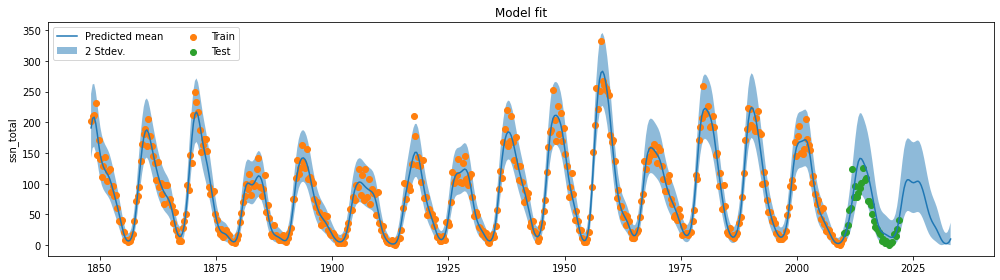

In [125]:
def plot_model_fit(model, figsize=(14, 4), transform=identity):
    pred, lower, upper = model.predict(all_x)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 1
    else:
        ts = [(identity, 'transformed ssn_total'), (transform, 'ssn_total')]
        nplots = 2
    fig, ax = plt.subplots(figsize=figsize)
    t, ylbl = ts[1]
    ax_t = ax
    ax_t.set_title('Model fit')
    ax_t.set_ylabel(ylbl)
    ax_t.plot(all_x, t(pred.mean).numpy().flatten(), label='Predicted mean')
    ax_t.fill_between(all_x, t(lower).numpy(), t(upper).numpy(), alpha=0.5, label='2 Stdev.')
    data_ = data.loc[data.year_frac > min_train_year]
    ax_t.scatter(train_x, t(transf_train_y), label='Train')
    ax_t.scatter(test_x, t(transf_test_y), label='Test')
    ax_t.legend(loc='upper left', ncol=2)

    fig.tight_layout()
    return fig, ax

print(f'BIC {calc_BIC(model, train_x, transf_train_y, train=True):.2f}')
print(f'train log-likelihood: {data_loglik(model, train_x, transf_train_y)/train_x.shape[0]:.2f}')
print(f'BIC {calc_BIC(model, test_x, transf_test_y):.2f}')
print(f'test log-likelihood: {data_loglik(model, test_x, transf_test_y)/test_x.shape[0]:.2f}')
fig, ax = plot_model_fit(model, transform=output_transform)
fig.savefig('./kernel-search-skm-se-per-rq-m25-NLL.png')

freq peaks at: 28.01 (84.42), 6.87 (74.99), 83.32 (15.19), 5.57 (1.68), 4.13 (0.00)
freq peaks at: 3.42 (19.05), 5.30 (0.50), 10.38 (0.00), 256.36 (0.00), 35.08 (0.00), 11.34 (0.00)
freq peaks at: 36.62 (77.35), 0.80 (0.00), 11.49 (0.00), 10.86 (0.00), 9.95 (0.00), 5.14 (0.00)


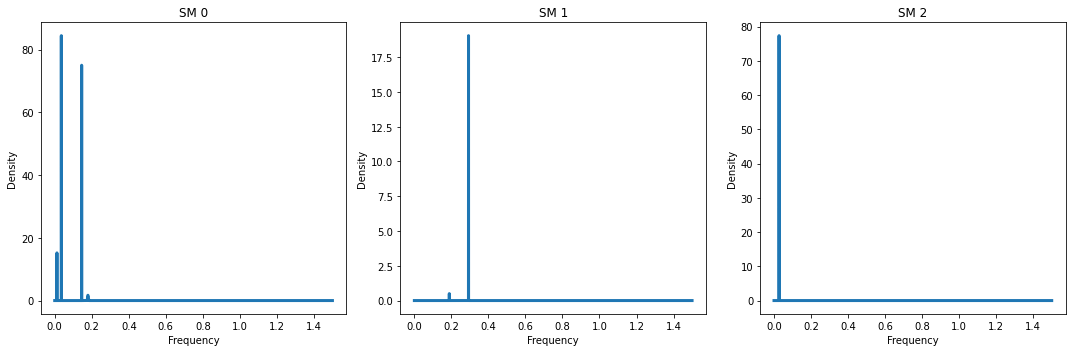

In [141]:
# look at the fit smk kernels... 
smks = [
    model.cov.kernels[0].kernels[0], 
    model.cov.kernels[0].kernels[1], 
    model.cov.kernels[1], 
]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i,smk in enumerate(smks): 
    density = spectral_density(smk)
    nyquist = f_s/2
    freq = torch.linspace(0, nyquist, 5000).reshape(-1, 1)
    density2 = density.log_prob(freq).exp()
    plot_density(freq, density2, ax=ax[i])
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'SM {i}')
    peak_freq, peak_density = get_peaks(freq, density2)
    print(f'freq peaks at: {", ".join([f"{1/f:.2f} ({d:.2f})" for f,d in zip(peak_freq, peak_density)])}')
ax[0]
fig.tight_layout()
fig.savefig('./smk888-spetra.png')


## search with all, loglikelihood as criteria

In [32]:
%%time
kernel_cache, nll_cache = kernel_search(train_x, transf_train_y, 
                                        base_kernels, base_kernel_names,
                                        base_compositions, base_composition_names, 
                                        4, criteria=nll, 
                                            test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000, 
                                       )

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:20<00:00, 49.81it/s, loss=1.63]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:19<00:00, 50.13it/s, loss=1.63]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:19<00:00, 50.35it/s, loss=1.57]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:19<00:00, 51.58it/s, loss=1.6]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training da

[INFO] finished base kernel search
        best BIC: 173.3403311617003
        best kernel: smk_6
    
[INFO] beginning composite kernel search, depth=0


Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s, loss=1.62]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:23<00:00, 43.41it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:21<00:00, 46.98it/s, loss=1.57]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:21<00:00, 46.79it/s, loss=1.59]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training d

Epoch: 100%|██████████| 1000/1000 [00:23<00:00, 41.71it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:23<00:00, 42.97it/s, loss=1.56]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s, loss=1.57]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 43.64it/s, loss=1.56]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training d

[INFO] finished composite kernel search, depth=0
            best BIC: 178.19452567238113
            best kernel: (smk_6*rq)
        
[INFO] could not find a better composite kernel at depth 0; aborting
CPU times: user 5h 28min 58s, sys: 5min 9s, total: 5h 34min 8s
Wall time: 24min 12s


In [33]:
nll_cache

{0: {'smk_6': 173.3403311617003,
  'smk_8': 195.45397836177293,
  'smk_10': 212.1778016482713},
 1: {'(smk_6+periodic)': 182.82717795509598,
  '(smk_6+rbf)': 181.81086635306565,
  '(smk_6+rq)': 182.37082572120926,
  '(smk_6+matern_2.5)': 179.7273092241594,
  '(smk_6*periodic)': 188.26940055031082,
  '(smk_6*rbf)': 184.0953969927141,
  '(smk_6*rq)': 178.19452567238113,
  '(smk_6*matern_2.5)': 184.30068111136643}}

In [ ]:
# %% analysis
best_crit = min(i for v in nll_cache.values() for i in list(v.values()))
for d in range(len(nll_cache)):
    for k,v in nll_cache[d].items():
        if v == best_crit: 
            kname = k
            break

k = kernel_cache[depth][kname]

model, score = fit_model_repeat(x, y, k, 5, training_iter=2000)

BIC 1627.30
train log-likelihood: -1.18
BIC 119.37
test log-likelihood: -1.46


/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


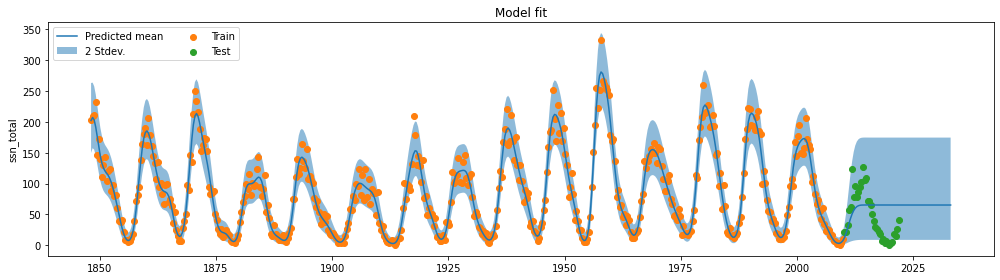

In [95]:
def plot_model_fit(model, figsize=(14, 4), transform=identity):
    pred, lower, upper = model.predict(all_x)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 1
    else:
        ts = [(identity, 'transformed ssn_total'), (transform, 'ssn_total')]
        nplots = 2
    fig, ax = plt.subplots(figsize=figsize)
    t, ylbl = ts[1]
    ax_t = ax
    ax_t.set_title('Model fit')
    ax_t.set_ylabel(ylbl)
    ax_t.plot(all_x, t(pred.mean).numpy().flatten(), label='Predicted mean')
    ax_t.fill_between(all_x, t(lower).numpy(), t(upper).numpy(), alpha=0.5, label='2 Stdev.')
    data_ = data.loc[data.year_frac > min_train_year]
    ax_t.scatter(train_x, t(transf_train_y), label='Train')
    ax_t.scatter(test_x, t(transf_test_y), label='Test')
    ax_t.legend(loc='upper left', ncol=2)

    fig.tight_layout()
    return fig, ax

print(f'BIC {calc_BIC(model, train_x, transf_train_y, train=True):.2f}')
print(f'train log-likelihood: {data_loglik(model, train_x, transf_train_y)/train_x.shape[0]:.2f}')
print(f'BIC {calc_BIC(model, test_x, transf_test_y):.2f}')
print(f'test log-likelihood: {data_loglik(model, test_x, transf_test_y)/test_x.shape[0]:.2f}')
fig, ax = plot_model_fit(model, transform=output_transform)
fig.savefig('./kernel-search-all-NLL.png')

## smk fit

In [ ]:
k = base_kernels[3]
model, bic = fit_model_repeat(x, y, k, 5, training_iter=2000, criteria=calc_BIC)

/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


BIC 1264.23
train log-likelihood: -1.17
test log-likelihood: -1.36
freq peaks at: 128.18 (422.22), 11.04 (89.34), 9.89 (82.22)


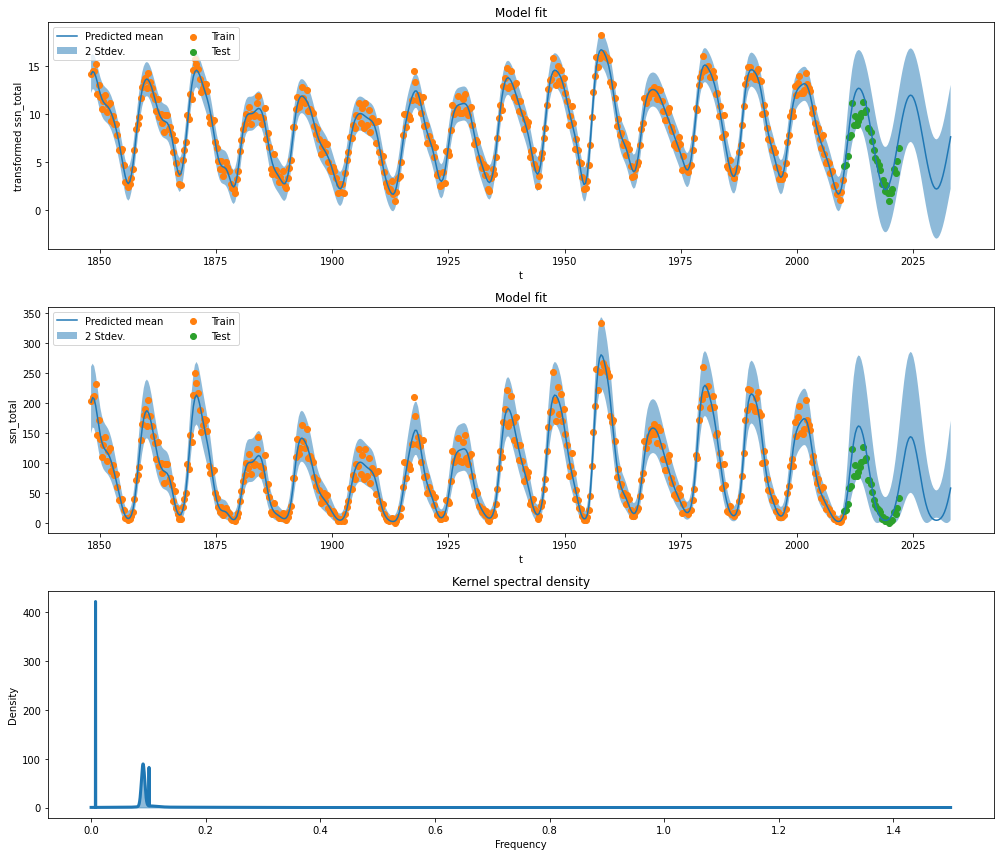

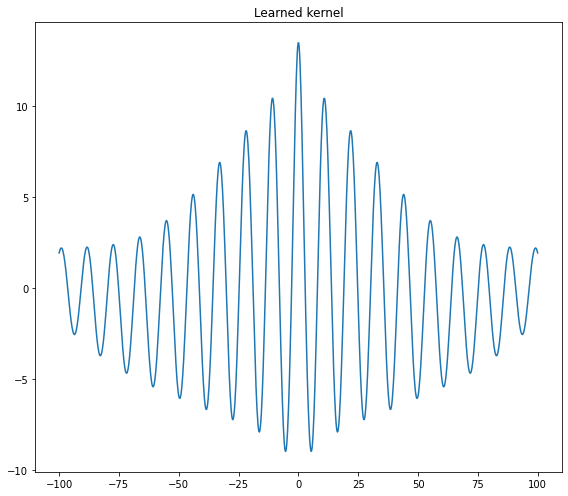

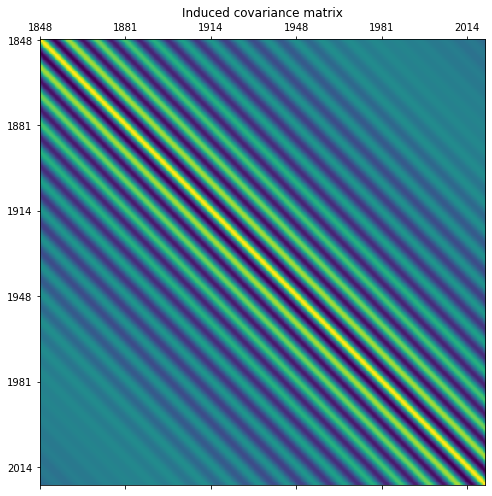

In [56]:
smk = model.cov

def plot_model_fit(model, smk, f_s=12, figsize=(14, 12), transform=identity):
    pred, lower, upper = model.predict(all_x)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 2
    else:
        ts = [(identity, 'transformed ssn_total'), (transform, 'ssn_total')]
        nplots = 3
    fig, ax = plt.subplots(nplots, 1, figsize=figsize)
    for i,(t,ylbl) in enumerate(ts): 
        ax_t = ax[i]
        ax_t.set_title('Model fit')
        ax_t.set_xlabel('t')
        ax_t.set_ylabel(ylbl)
        ax_t.plot(all_x, t(pred.mean).numpy().flatten(), label='Predicted mean')
        ax_t.fill_between(all_x, t(lower).numpy(), t(upper).numpy(), alpha=0.5, label='2 Stdev.')
        data_ = data.loc[data.year_frac > min_train_year]
        # ax_t.scatter(data_.year_frac, t(input_transform(data_.ssn_total)), label='Raw obs.', marker='x', alpha=0.3)
        ax_t.scatter(train_x, t(transf_train_y), label='Train')
        ax_t.scatter(test_x, t(transf_test_y), label='Test')
        ax_t.legend(loc='upper left', ncol=2)

    density = spectral_density(smk)
    nyquist = f_s/2
    freq = torch.linspace(0, nyquist, 5000).reshape(-1, 1)
    density2 = density.log_prob(freq).exp()
    plot_density(freq, density2, ax=ax[nplots-1])
    ax[nplots-1].set_ylabel('Density')
    fig.tight_layout()
    return freq, density2, fig, ax

smk = model.cov

print(f'BIC {calc_BIC(model, train_x, transf_train_y):.2f}')
print(f'train log-likelihood: {data_loglik(model, train_x, transf_train_y) / train_x.shape[0]:.2f}')
print(f'test log-likelihood: {data_loglik(model, test_x, transf_test_y) / test_x.shape[0]:.2f}')
freq, density, fig, ax = plot_model_fit(model, smk, f_s=f_s, transform=output_transform)
peak_freq, peak_density = get_peaks(freq, density)
print(f'freq peaks at: {", ".join([f"{1/f:.2f} ({d:.2f})" for f,d in zip(peak_freq, peak_density)])}')
fig.savefig('./smk-fit.png')

def plot_model_kernel(kernel, figsize=(8, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    plot_kernel(kernel, xx=torch.linspace(-100, 100, 1000), ax=ax)
    ax.set_title('Learned kernel')
    fig.tight_layout()
    return fig, ax

def plot_covariance(kernel, grid, figsize=(8, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(kernel(grid, grid).numpy())
    tickindex = [int(i) for i in ax.get_xticks()[1:-1]]
    ticklabels = grid.numpy()[tickindex].tolist() 
    ticklabels = [f'{int(l)}' for l in ticklabels]
    ax.set_xticks(tickindex)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(tickindex)
    ax.set_yticklabels(ticklabels)
    ax.set_title('Induced covariance matrix')
    fig.tight_layout()
    return fig, ax

fig, ax = plot_model_kernel(model.cov)
fig.savefig('./smk-kernel.png')
fig, ax = plot_covariance(model.cov, history_x)
fig.savefig('./smk-covariance.png')

In [46]:
pred, lower, upper = model.predict(all_x)

In [52]:
list(zip(all_x.tolist(), output_transform(pred.mean).tolist()))

[(1848.1666259765625, 200.82424926757812),
 (1848.5, 208.80047607421875),
 (1848.8333740234375, 206.18833923339844),
 (1849.1666259765625, 194.79241943359375),
 (1849.5, 178.30130004882812),
 (1849.8333740234375, 160.81912231445312),
 (1850.1666259765625, 145.57095336914062),
 (1850.5, 134.19085693359375),
 (1850.8333740234375, 126.76226043701172),
 (1851.1666259765625, 122.23204803466797),
 (1851.5, 118.93684387207031),
 (1851.8333740234375, 115.22819519042969),
 (1852.1666259765625, 109.93583679199219),
 (1852.5, 102.65815734863281),
 (1852.8333740234375, 93.65230560302734),
 (1853.1666259765625, 83.471435546875),
 (1853.5, 72.5836181640625),
 (1853.8333740234375, 61.27132797241211),
 (1854.1666259765625, 49.723548889160156),
 (1854.5, 38.299686431884766),
 (1854.8333740234375, 27.71554946899414),
 (1855.1666259765625, 18.87533950805664),
 (1855.5, 12.487985610961914),
 (1855.8333740234375, 8.759957313537598),
 (1856.1666259765625, 7.521360397338867),
 (1856.5, 8.774076461791992),
 (